In [43]:
import os
import sys

sys.path.append(os.path.realpath('..'))

import pandas as pd
pd.options.display.max_colwidth = 100

import numpy as np

### How to get cefi-defi trades
1. We get all the transactions which have paid rewards directly to the coinbase address
2. Of those transactions we check the number of token transfers and number of unique tokens transferred

We assume that if a transaction pays directly to coinbase address
And has 2 token transfers and 2 unique tokens transferred then it should be a cefi-defi trade

**Note**: This is a very crude assumption there is possibility of false negative but we are doing this analysis to estimate a lower bound on these activities

In [70]:
df = pd.read_gbq(
"""
select concat(unique_token, num_token_transfers) as cefidefi, concat(CAST(EXTRACT(MONTH from timestamp) as string), "-", CAST(EXTRACT(YEAR from timestamp) as string)) as monthyear, sum(reward) as total_reward
from
(select number, miner, timestamp, value/pow(10, 18) as reward, token.num_token_transfers, token.unique_token, token.transaction_hash from
(SELECT number, timestamp, miner 
FROM `bigquery-public-data.crypto_ethereum.blocks` 
WHERE DATE(timestamp) > "2022-10-01") as b
inner join 
(
  SELECT block_number, to_address, from_address, value, transaction_hash, transaction_index FROM `bigquery-public-data.crypto_ethereum.traces` 
WHERE DATE(block_timestamp) > "2022-10-01"
and value > 0
and status = 1
) as tr
on b.number = tr.block_number and tr.to_address = b.miner
inner join
(
  SELECT transaction_hash, count(1) as num_token_transfers, count(distinct(token_address)) as unique_token FROM `bigquery-public-data.crypto_ethereum.token_transfers` 
WHERE DATE(block_timestamp) > "2022-10-01"
group by transaction_hash
) as token
on tr.transaction_hash = token.transaction_hash)
group by 1, 2
"""
)

In [71]:
df['cefi-defi'] = np.where(df['cefidefi'] == '22', 'CeFi-DeFi', 'Others')

In [80]:
df_cefidefi = df.groupby(['monthyear', 'cefi-defi']).sum()['total_reward'].reset_index()
to_plot = df_cefidefi.pivot(index="monthyear", columns="cefi-defi", values="total_reward")
new_order = ['10-2022', '11-2022', '12-2022', '1-2023', '2-2023']
to_plot = to_plot.reindex(new_order, axis=0)

/var/folders/vm/n0lnd6g946l4l6jlzv2954m40000gn/T/ipykernel_51426/1948779259.py:1: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  df_cefidefi = df.groupby(['monthyear', 'cefi-defi']).sum()['total_reward'].reset_index()


Text(0, 0.5, 'Rewards to Coinbase in ETH')

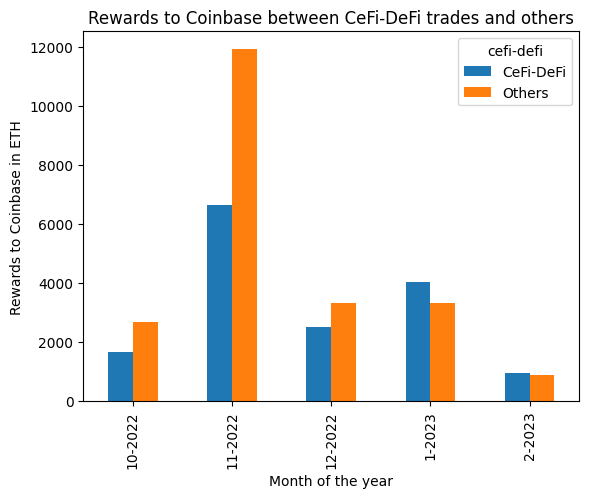

In [81]:
ax = to_plot.plot.bar()
ax.set_title('Rewards to Coinbase between CeFi-DeFi trades and others')
ax.set_xlabel('Month of the year')
ax.set_ylabel('Rewards to Coinbase in ETH')

Text(0.5, 0, 'Month of the year')

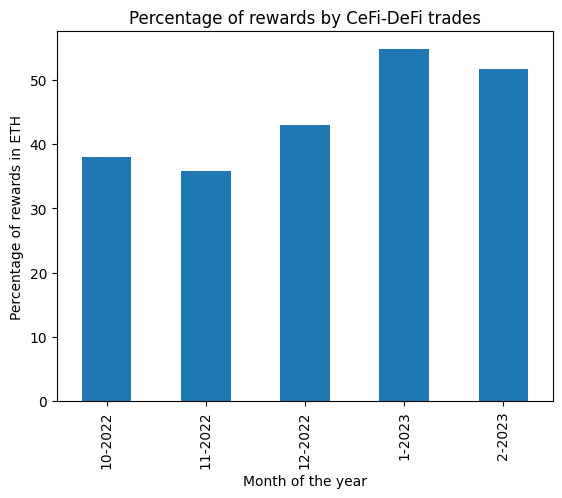

In [98]:
to_plot['pct_cefidefi'] = to_plot['CeFi-DeFi']*100/(to_plot['CeFi-DeFi']+to_plot['Others'])
ax = to_plot.plot(y='pct_cefidefi', kind='bar', legend=False)
ax.set_title('Percentage of rewards by CeFi-DeFi trades')
ax.set_ylabel('Percentage of rewards in ETH')
ax.set_xlabel('Month of the year')

### Split between cefi-defi arbs vs others 
54% of coinbase rewards are due to cefi-defi trades

In [76]:
df_cefidefi.groupby('cefi-defi').sum()

/var/folders/vm/n0lnd6g946l4l6jlzv2954m40000gn/T/ipykernel_51426/3082638410.py:1: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  df_cefidefi.groupby('cefi-defi').sum()


,total_reward
cefi-defi,
CeFi-DeFi,15775.420342
Others,22135.540249


In [101]:
15775.420342/(22135.540249+15775.420342)

0.4161176634955817